In [ ]:
# ------------------------------------------------------------------------------
# Set training variables
# ------------------------------------------------------------------------------

# System level
# import sys

# Future functions
#from __future__ import print_function

# Arrays
import numpy as np

# Keras (www.keras.io)
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# Sklearn (for machine learning)
from sklearn import metrics

# Plots
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline



In [5]:
# ------------------------------------------------------------------------------
# Set variables
# ------------------------------------------------------------------------------

# training variables
nb_train = 8000  # number of objects for training (of both classes)
nb_valid = 1000  # ... validation
nb_test = 1000   # ... test
nb_epoch = 10    # number of passes over full neural network during training
nb_classes = 3   # number of classes (i.e., lens or non-lens)
batch_size = 128 # number objects to put in memory at once 

# data location
#dir_test = "/Users/jmartine/teaching/dotastro/ML/Data161/"
#dir_test = "/Users/jmartine/teaching/dotastro/hackday/CNNphot/data/"


In [1]:
dir_test = "data/"

In [6]:
# ------------------------------------------------------------------------------
# Read in Data
# ------------------------------------------------------------------------------

# set file names for data
file_x_data = dir_test + "image_data_v9.npy" # x data (images)
file_y_data = dir_test + "label_data_v9.npy" # y data (labels)
f_model = dir_test + "model.json" # model data (architecture)
f_weights = dir_test + "weights.h5" # model data (weights that we fit for)

# load data
x_data = np.load(file_x_data)
#x_data = np.expand_dims(x_data, axis=2)
y_data = np.load(file_y_data)
y_data = y_data - 1

x_data = np.swapaxes(x_data,0,1)
print (np.shape(x_data))

# check data sizes
statement =  "#TrainingSamples + #ValidSamples #TestSamples > TotalSamples, exiting!!!"
nb_total = nb_train + nb_test + nb_valid
assert nb_total <= len(x_data), statement

# indices for where to slice the arrays
ind_valid_start = ind_train_end = nb_train
ind_valid_end = ind_test_start = nb_train + nb_valid
ind_test_end = nb_train + nb_valid + nb_test

# slice the image arrays
x_train = x_data[ :ind_train_end, :, :, :]
#x_train = np.expand_dims(x_train, axis=1)
x_valid = x_data[ind_valid_start: ind_valid_end, :, :, :]
#x_valid = np.expand_dims(x_valid, axis=1)
x_test = x_data[ind_test_start: ind_test_end, :, :, :]
#x_test = np.expand_dims(x_test, axis=1)

# slice the label arrays
y_train = y_data[:ind_train_end]
y_valid = y_data[ind_valid_start: ind_valid_end]
y_test = y_data[ind_test_start: ind_test_end]

# cast data types
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

print("Data dimensions: ")
print("Input data: \t ", np.shape(x_data), np.shape(y_data))
print("Training set: \t ", np.shape(x_train), np.shape(y_train))
print("Validation set:  ", np.shape(x_valid), np.shape(y_valid))
print("Test Set:   \t ", np.shape(x_test), np.shape(y_test))


(10000, 2, 20, 20)
Data dimensions: 
Input data: 	  (10000, 2, 20, 20) (10000,)
Training set: 	  (8000, 2, 20, 20) (8000,)
Validation set:   (1000, 2, 20, 20) (1000,)
Test Set:   	  (1000, 2, 20, 20) (1000,)


2


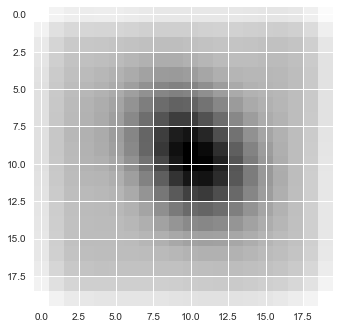

In [10]:
i=11
plt.imshow((x_data[i][0,:,:]))
print(y_data[i])

In [11]:
print(len(y_train[y_train==0]))
print(len(y_train[y_train==1]))
print(len(y_train[y_train==2]))


2681
2625
2694


In [6]:
# ------------------------------------------------------------------------------
# Set up model architecture
# ------------------------------------------------------------------------------

# Define architecture for model
data_shape = np.shape(x_data)
input_shape = (2, 20, 20)
x = Input(shape=input_shape)
c0 = Convolution2D(8, (4, 4), activation='relu', subsample=(4, 4), border_mode='same', dim_ordering='th')(x)
b0 = BatchNormalization()(c0)
d0 = Dropout(0.5)(b0)
c1 = Convolution2D( 4, (3, 3), activation='relu', subsample=(2, 2), border_mode='same')(d0)
b1 = BatchNormalization()(c1)
d1 = Dropout(0.5)(b1)
f = Flatten()(d1)
z0 = Dense(128, activation='relu')(f)
z1 = Dense(32, activation='relu')(z0)
#y = Dense(1, activation='sigmoid')(z1)
y = Dense(3, activation='softmax')(z1)
model = Model(input=x, output=y)


/Users/jmartine/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (4, 4), activation="relu", strides=(4, 4), padding="same", data_format="channels_first")`
  if __name__ == '__main__':
/Users/jmartine/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), activation="relu", strides=(2, 2), padding="same")`
  if sys.path[0] == '':
/Users/jmartine/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [7]:
# Compile Model
optimizer = 'rmsprop'
metrics_model = ['accuracy']
loss = 'sparse_categorical_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=metrics_model)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 20, 20)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 5, 5)           264       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 5, 5)           20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 5, 5)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 3, 4)           184       
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 3, 4)           16        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 3, 4)           0         
__________

In [8]:
# ------------------------------------------------------------------------------
# Train model (using 'train' and 'valid' data)
# ------------------------------------------------------------------------------

# Train 
history = model.fit(
                    x_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    validation_data=(x_valid, y_valid),
                    verbose=True
                    )
# Save data
model.save_weights(f_weights, overwrite=True)
open(f_model, 'w').write(model.to_json())


/Users/jmartine/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 8000 samples, validate on 1000 samples
Epoch 1/10
8000/8000 [==============================] - 1s 183us/step - loss: 1.1335 - acc: 0.3342 - val_loss: 1.1036 - val_acc: 0.2960
Epoch 2/10
8000/8000 [==============================] - 1s 91us/step - loss: 1.1045 - acc: 0.3505 - val_loss: 1.0861 - val_acc: 0.2970
Epoch 3/10
8000/8000 [==============================] - 1s 87us/step - loss: 1.0596 - acc: 0.4148 - val_loss: 1.2832 - val_acc: 0.2960
Epoch 4/10
8000/8000 [==============================] - 1s 100us/step - loss: 0.9405 - acc: 0.5272 - val_loss: 1.4561 - val_acc: 0.2960
Epoch 5/10
8000/8000 [==============================] - 1s 100us/step - loss: 0.9000 - acc: 0.5573 - val_loss: 1.3676 - val_acc: 0.2960
Epoch 6/10
8000/8000 [==============================] - 1s 94us/step - loss: 0.8841 - acc: 0.5707 - val_loss: 1.4518 - val_acc: 0.2960
Epoch 7/10
8000/8000 [==============================] - 1s 112us/step - loss: 0.8827 - acc: 0.5735 - val_loss: 1.2377 - val_acc: 0.2960
Epo

5089

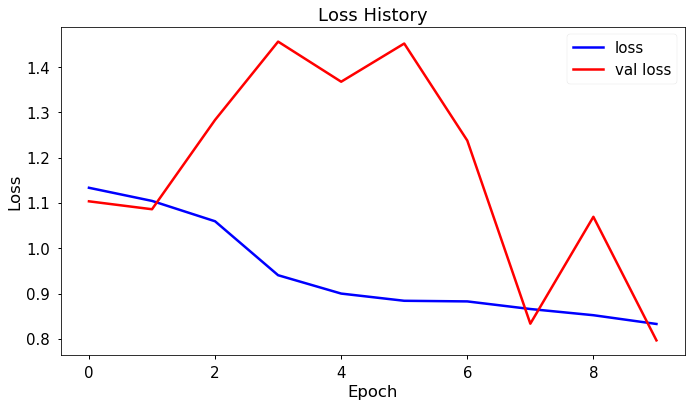

In [9]:
# ------------------------------------------------------------------------------
# Plot: Loss History during Training and Receiver-Operator Curve (ROC)
# ------------------------------------------------------------------------------

try:
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
except: 
    pass
hist = history.history
loss = hist['loss']
val_loss = hist["val_loss"]
epochs = np.arange(nb_epoch)
fig, axis1 = plt.subplots(figsize=(10,6))
plt.plot(epochs, loss, 'b', label='loss')
plt.plot(epochs, val_loss, 'r', label="val loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss History")
plt.legend(loc='upper right')
plt.tight_layout()


In [10]:
# ------------------------------------------------------------------------------
# Evaluate (using 'test' data)
# ------------------------------------------------------------------------------

# predict on 'test'
y_prob = model.predict(x_test) # probability of being a lens
#y_pred = (y_prob > 0.5).astype('int32') # binary classification
y_pred = [np.argmax(y_prob[i])for i in range(len(y_prob))]

# measure confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]

print (cm_norm)


acc = sum([y_pred[i]==y_test[i] for i in range(len(y_pred))])/len(y_pred)

print ([y_pred[i]==y_test[i] for i in range(len(y_pred))][0:100])
print (1+np.array(y_test[0:100]))
print (1+np.array(y_pred[0:100]))

print (acc)


print()
print("AUC:", acc)


[[0.97689769 0.02310231 0.        ]
 [0.21036585 0.78963415 0.        ]
 [0.01355014 0.98373984 0.00271003]]
[False, True, False, False, True, False, True, False, False, True, False, True, False, True, False, False, False, True, True, False, True, False, True, False, False, True, True, False, False, True, True, False, True, True, True, False, False, True, False, False, False, True, False, True, False, True, False, False, True, True, False, True, True, True, True, True, False, True, True, True, False, True, True, False, False, True, False, True, True, True, False, False, False, False, False, True, False, True, False, True, True, False, False, False, True, True, True, False, False, False, False, True, True, True, True, False, False, False, True, False]
[2 2 3 3 2 3 1 3 3 2 1 1 3 1 3 3 3 2 2 3 1 3 1 3 3 1 1 3 3 1 2 2 1 2 1 3 3
 2 3 2 3 1 3 2 3 2 3 3 2 2 3 1 1 1 2 2 3 1 1 1 3 2 1 3 2 2 2 1 2 1 3 3 3 3
 3 1 3 1 2 2 2 3 3 3 2 1 1 3 3 3 3 1 2 2 1 3 3 1 1 3]
[1 2 2 2 2 2 1 2 2 2 2 1 2 1 2 2 2 

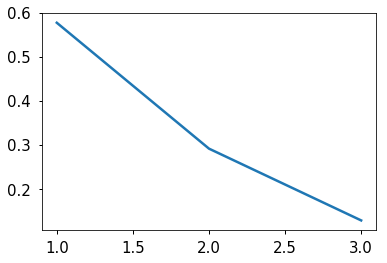

In [11]:
plt.plot([1,2,3],y_prob[91])

In [12]:
V0: ACC 0.934, Min_loss ~0.2, 50 epochs (0.5-1.0)
V1: ACC 0.657, Min_loss ~0.7, 120 epochs (0.0-1.0)
V2: ACC 0.818, Min_loss ~0.4, 70 epochs (0.3-1.0)
V3: ACC 0.830, Min_loss ~0


SyntaxError: invalid syntax (<ipython-input-12-4073f1a16c3c>, line 1)

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
# image shape
image_shape = (64, 64)

random_seed = 1
np.random.seed(random_seed)

# load faces data
faces_dataset = fetch_olivetti_faces(shuffle=True, random_state=random_seed)
faces = faces_dataset.data
n_samples, n_features = faces.shape

# function to visualize images
def plot_face(ax, img, image_shape):
    vmax = max(img.max(), -img.min())
    ax.imshow(img.reshape(image_shape), cmap=plt.cm.gray,
              interpolation='nearest',
              vmin=-vmax, vmax=vmax)
    return ax

/Users/jmartine/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jmartine/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
print(faces)

[[0.21487603 0.21900827 0.21900827 ... 0.57438016 0.59090906 0.60330576]
 [0.6570248  0.6652893  0.69008267 ... 0.3305785  0.32231405 0.3429752 ]
 [0.11983471 0.11157025 0.11570248 ... 0.6528926  0.77272725 0.74380165]
 ...
 [0.3677686  0.3677686  0.35123968 ... 0.4876033  0.5123967  0.5495868 ]
 [0.21487603 0.2644628  0.3429752  ... 0.45867768 0.446281   0.446281  ]
 [0.10330579 0.21900827 0.17768595 ... 0.43801653 0.4752066  0.2768595 ]]


In [3]:
labels = faces_dataset.target
# take images from only two individuals
X_flat = faces[(labels == 0) | (labels == 1) | (labels == 2)]
X_flat.shape
X = X_flat.reshape((30, 64, 64, 1))
Y = labels[(labels == 0) | (labels == 1) | (labels == 2)]

In [4]:
print(Y)

[2 0 1 0 0 1 1 2 1 2 1 1 0 1 0 1 0 2 2 2 1 2 0 2 1 2 0 0 2 0]


In [5]:
from matplotlib import pyplot as plt
# we plot two sample images from the data set
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0] = plot_face(ax[0], X[Y == 0][0], image_shape)
ax[1] = plot_face(ax[1], X[Y == 1][0], image_shape)
ax[2] = plot_face(ax[2], X[Y == 2][0], image_shape)
plt.show()

In [6]:
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling1D
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization

# kernel size
kernel_size = (8, 8)
stride_size = (1, 1)
filters = 3

cnn_model = Sequential()
# feature extraction layer 0: convolution
cnn_model.add(Conv2D(filters, kernel_size=kernel_size, strides=stride_size,
                 activation='relu',
                 input_shape=(64, 64, 1)))
# batch normalization
cnn_model.add(BatchNormalization())
# Dropout
cnn_model.add(Dropout(0.5))
# feature extraction layer 1: max pooling
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# classification layer 2: flattening
cnn_model.add(Flatten())
# classification layer 3: dense non-linear transformation
cnn_model.add(Dense(100, activation='relu'))
# classification layer 4: output label probability
cnn_model.add(Dense(1, activation='softmax'))

cnn_model.compile(loss='binary_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])

Using TensorFlow backend.
/Users/jmartine/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [7]:
# fit the model
cnn_model.fit(X, Y, batch_size=20, epochs=500, verbose=0)

ValueError: Error when checking target: expected dense_2 to have shape (3,) but got array with shape (1,)

In [8]:
# evaluate the training and testing performance of your model 
# note: you should extract check both the loss function and your evaluation metric
score = cnn_model.evaluate(X, Y, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 6.357829107628277e-08
Train accuracy: 0.3333333432674408
